# Prepare Data
## Target Specification:

1. Gasoline: FIC15613, GSO_FLOW
2. Lean Gas: FI18301, LGO_FLOW
3. LPG: FIC15621, LPG_FLOW
4. LCO: FIC15336, LCO_FLOW
5. Slurry(CSO) : FIC15308, CSO_FLOW

In [1]:
import numpy as np
import pandas as pd

method = "KNN"

if method == "Mean":

    df = pd.read_csv("data/DatasWithIQROutlier.csv").iloc[:276, :]
    feed = pd.read_csv("data/filled_feed.csv").iloc[:276, :]
    feed.drop("Date", axis=1, inplace=True)
    targets = pd.read_csv("data/target.csv").iloc[:276, :]
    targets.replace(0, np.nan, inplace=True)
    inputs = pd.concat([df, feed], axis=1)
    
    # Imputation with Mean Statistic
    from sklearn.impute import SimpleImputer
    
    imputer = SimpleImputer()
    
    inputs_filled = imputer.fit_transform(inputs)
    inputs = pd.DataFrame(data=inputs_filled, columns=inputs.columns)  
    
    GSO_FLOW = pd.concat([inputs, pd.DataFrame(targets["FIC15613"])], axis=1).sample(frac=1).reset_index(drop=True).astype("float32").dropna(subset=["FIC15613"])
    LGO_FLOW = pd.concat([inputs, pd.DataFrame(targets["FI18301"])], axis=1).sample(frac=1).reset_index(drop=True).astype("float32").dropna(subset=["FI18301"])
    LPG_FLOW = pd.concat([inputs, pd.DataFrame(targets["FIC15621"])], axis=1).sample(frac=1).reset_index(drop=True).astype("float32").dropna(subset=["FIC15621"])
    LCO_FLOW = pd.concat([inputs, pd.DataFrame(targets["FIC15336"])], axis=1).sample(frac=1).reset_index(drop=True).astype("float32").dropna(subset=["FIC15336"])
    CSO_FLOW = pd.concat([inputs, pd.DataFrame(targets["FIC15308"])], axis=1).sample(frac=1).reset_index(drop=True).astype("float32").dropna(subset=["FIC15308"])
    

# Imputation with KNN

if method == "KNN":
    df = pd.read_csv("data/DatasWithIQROutlier.csv").iloc[:276, :]
    feed = pd.read_csv("data/filled_feed.csv").iloc[:276, :]
    feed.drop("Date", axis=1, inplace=True)
    targets = pd.read_csv("data/target.csv").iloc[:276, :]
    targets.replace(0, np.nan, inplace=True)
    inputs = pd.concat([df, feed], axis=1)
    
    q25, q75 = targets.quantile(0.25), targets.quantile(0.75)
    iqr = q75 - q25
    cut_off = iqr * 1.5
    lower_bound, upper_bound = q25 - cut_off, q75 + cut_off
    targets = targets[(targets > lower_bound) & (targets < upper_bound)]
    
    GSO_FLOW = pd.concat([inputs, pd.DataFrame(targets["FIC15613"])], axis=1).sample(frac=1).reset_index(drop=True).astype("float32").dropna(subset=["FIC15613"])
    LGO_FLOW = pd.concat([inputs, pd.DataFrame(targets["FI18301"])], axis=1).sample(frac=1).reset_index(drop=True).astype("float32").dropna(subset=["FI18301"])
    LPG_FLOW = pd.concat([inputs, pd.DataFrame(targets["FIC15621"])], axis=1).sample(frac=1).reset_index(drop=True).astype("float32").dropna(subset=["FIC15621"])
    LCO_FLOW = pd.concat([inputs, pd.DataFrame(targets["FIC15336"])], axis=1).sample(frac=1).reset_index(drop=True).astype("float32").dropna(subset=["FIC15336"])
    CSO_FLOW = pd.concat([inputs, pd.DataFrame(targets["FIC15308"])], axis=1).sample(frac=1).reset_index(drop=True).astype("float32").dropna(subset=["FIC15308"])
    
    from sklearn.impute import KNNImputer
    my_data = [GSO_FLOW, LGO_FLOW, LPG_FLOW, LCO_FLOW, CSO_FLOW]
    for i in range(5):
            
        imputer = KNNImputer()
        data = imputer.fit_transform(my_data[i])
        my_data[i] = pd.DataFrame(data, columns=my_data[i].columns)
    GSO_FLOW, LGO_FLOW, LPG_FLOW, LCO_FLOW, CSO_FLOW = my_data[0], my_data[1], my_data[2], my_data[3], my_data[4]

# GSO with SVR

_ Iteration: 0 Max score: 0.9439 Avg score 0.9322
Time:  36.75676740000017
_ Iteration: 1 Max score: 0.9472 Avg score 0.9389
Time:  38.730975299999955
_ Iteration: 2 Max score: 0.9518 Avg score 0.9426
Time:  38.21905229999993
_ Iteration: 3 Max score: 0.9513 Avg score 0.9453
Time:  37.50114630000007
_ Iteration: 4 Max score: 0.9520 Avg score 0.9471
Time:  38.206673099999534
_ Iteration: 5 Max score: 0.9521 Avg score 0.9486
Time:  37.50012270000025
_ Iteration: 6 Max score: 0.9534 Avg score 0.9492
Time:  38.65758370000003
_ Iteration: 7 Max score: 0.9526 Avg score 0.9502
Time:  37.30444390000048
_ Iteration: 8 Max score: 0.9533 Avg score 0.9502
Time:  38.32032580000032
_ Iteration: 9 Max score: 0.9538 Avg score 0.9510
Time:  37.46444580000025
_ Iteration: 10 Max score: 0.9544 Avg score 0.9517
Time:  37.61515070000041
_ Iteration: 11 Max score: 0.9560 Avg score 0.9520
Time:  38.61292009999943
_ Iteration: 12 Max score: 0.9555 Avg score 0.9531
Time:  39.27501780000057
_ Iteration: 13 Max 

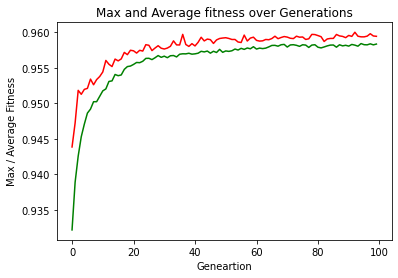

In [3]:
from Ant_algo import *
import pandas as pd
import numpy as np
import timeit
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import pickle

# Evolving the solution
X, y = get_data(GSO_FLOW)
eval_class = Evaluate(X, y, SVR())
iterationCounter = 0

NUM_ANTS = 30
NUM_FEATURES = len(eval_class)
MAX_ITERATION = 100
ALPHA = 2
BETA = 1
RO = 0.2
HOF = 10
RANDOM_SEED = 42
FEATURE_PENALTY_FACTOR = 0.001

random.seed(RANDOM_SEED)


max_evaluate = list()
mean_evaluate = list()

eta = corr(n_f=NUM_FEATURES, data=X)
pher = pheromone(n_f=NUM_FEATURES)
features = map_features(n_f=NUM_FEATURES)
all_time = list()
best_ants = list()

while iterationCounter < MAX_ITERATION:
    now = timeit.default_timer()
    iterationCounter += 1
    colony = Colony()
    best = 0
    for i in range(NUM_ANTS):
        ant = Ant()
        select_next_feature(features, n_f=NUM_FEATURES, ant=ant, pher=pher, eta=eta, alpha=ALPHA, beta=BETA)
        colony.colony_add(ant)
    
#     if iterationCounter != 1:
#         for i in range(HOF):
#             colony.best_add(best_ants[i])
    

    pher_emp = pher_empty(n_f=NUM_FEATURES)
    
    best_indices, r2_best_indices, result_scores = colony.best(colony, eval_class, HOF)
    counter = 0
    best_ants = list()
    for i in best_indices:
        l = len(colony.colony[i])
        best_ants.append(colony.colony[i])
        r2_ant = r2_best_indices[counter]
        r2_update = 30 / ((1 - r2_ant) * (l))
        best_ant_pher = pher_change(n_f=NUM_FEATURES, ant_features_best=colony.ant_features[i],
                                    r2_best= r2_update)
        pher_emp = np.add(pher_emp, best_ant_pher)
        counter += 1
        
        
    pher = pheromone(n_f=NUM_FEATURES, n_iter=iterationCounter, pher_before=pher, pher_change=pher_emp, ro=RO)
    duration = timeit.default_timer() - now
    
    max_evaluate.append(np.max(result_scores))
    mean_evaluate.append(np.mean(result_scores))
    all_time.append(duration)

    print("_ Iteration: %d Max score: %.4f Avg score %.4f" % (iterationCounter - 1, np.max(result_scores), np.mean(result_scores)))
    print("Time: ", duration)
    
    best_ant = colony.colony[best_indices[0]]
    r2_best_ant = r2_best_indices[0]
    
print("Best Individual: " ,best_ant)
print("Number of features selected: ", len(best_ant))
print("Best R2: ", r2_best_ant)
print("Total Time Consumed: %.3f minutes" % float(sum(all_time)/60))
plt.plot(max_evaluate, color="red")
plt.plot(mean_evaluate, color="green")
plt.xlabel("Geneartion")
plt.ylabel("Max / Average Fitness")
plt.title("Max and Average fitness over Generations")
plt.savefig("plots/GSO_SVR_ant_plot", dpi=1000)
plt.show()

with open('objects/Ant_GSO_SVR.pkl', 'wb') as f:
    pickle.dump([colony, max_evaluate, mean_evaluate, best_ant, all_time, r2_best_ant, MAX_ITERATION], f)